# **LSTM Model creation**

In [ ]:
# Install and import libraries
!pip install --quiet scipy scikit-learn

import numpy as np, scipy.io as sio, tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import keras

In [ ]:
# Python version
print('Keras: {}'.format(keras.__version__))
print('TensorFlow: {}'.format(tf.__version__))

Keras: 3.8.0
TensorFlow: 2.18.0


In [ ]:
# Load the .mat file specified by the path.
# The 'dataset_split.mat' file should contain the X_train, y_train, etc., tensors generated in MATLAB.
mat = sio.loadmat('/content/dataset_split.mat')

# Extract training, validation, and test data from the loaded 'mat' dictionary.
# .astype('float32') converts numerical data to float32 type, common in neural networks for memory and computational efficiency.
# .squeeze() removes single-dimensional entries (e.g., [N, 1] becomes [N]), making label vectors more suitable for Keras/TensorFlow.
# .astype('int') converts labels to integer type.
X_train = mat['X_train'].astype('float32')
y_train = mat['y_train'].squeeze().astype('int')
X_val = mat['X_val'].astype('float32')
y_val = mat['y_val'].squeeze().astype('int')
X_test = mat['X_test'].astype('float32')
y_test = mat['y_test'].squeeze().astype('int')

# Reference: Class labels in MATLAB (and in your script) are often 1-based (1, 2, 3, ...).
# Machine Learning libraries in Python (like Keras/TensorFlow) expect 0-based labels (0, 1, 2, ...).
# This step decrements all labels by 1 to align them with this standard.
y_train -= 1
y_val -= 1
y_test -= 1
y_train -= 1
y_val -= 1
y_test -= 1

# Print the shapes of the training, validation, and test tensors.
print('X_train:', X_train.shape, '  X_val:', X_val.shape, ' X_test:', X_test.shape )

X_train: (38894, 100, 6)   X_val: (11015, 100, 6)  X_test: (5479, 100, 6)


In [ ]:
# Normalization on training data
mean = X_train.mean(axis=(0,1), keepdims=True)
std  = X_train.std(axis=(0,1), keepdims=True) + 1e-8

print(mean)
print(std)

X_train = (X_train - mean) / std
X_val   = (X_val   - mean) / std
X_test  = (X_test  - mean) / std

[[[-0.3109933  -0.21435975  4.9039526   0.12456421  0.06937116
   -0.03399972]]]
[[[ 84.00599  140.4055   224.9723    18.348589  17.98235   16.988403]]]


In [ ]:
# Neural Network model
seq_len   = X_train.shape[1]
n_feats   = X_train.shape[2]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100, 6)),
    tf.keras.layers.LSTM(100, return_sequences=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss      ='sparse_categorical_crossentropy',
    metrics   =['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        42,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,725 (182.52 KB)

 Trainable params: 46,461 (181.49 KB)

 Non-trainable params: 264 (1.03 KB)

# **Train e validation model**

In [ ]:
# Training model
BATCH  = 128
EPOCHS = 40

history = model.fit(
    X_train, y_train,
    epochs          = EPOCHS,
    batch_size      = BATCH,
    validation_data = (X_val, y_val),
    shuffle         = True,
    verbose         = 1,
    callbacks       = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1),
)

Epoch 1/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 56s 184ms/step - accuracy: 0.9556 - loss: 0.1328 - val_accuracy: 0.9405 - val_loss: 0.1923
Epoch 2/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 86s 198ms/step - accuracy: 0.9525 - loss: 0.1460 - val_accuracy: 0.9404 - val_loss: 0.2116
Epoch 3/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 55s 183ms/step - accuracy: 0.9571 - loss: 0.1344 - val_accuracy: 0.9446 - val_loss: 0.2412
Epoch 4/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 82s 182ms/step - accuracy: 0.9570 - loss: 0.1284 - val_accuracy: 0.9433 - val_loss: 0.1782
Epoch 5/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - accuracy: 0.9569 - loss: 0.1305 - val_accuracy: 0.9412 - val_loss: 0.2287
Epoch 6/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 55s 182ms/step - accuracy: 0.9605 - loss: 0.1216 - val_accuracy: 0.9403 - val_loss: 0.1905
Epoch 7/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 56s 184ms/step - accuracy: 0.9599 - loss: 0.1258 - val_accuracy: 0.9429 - val_loss: 0.1864
Epoch 8/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 82s 183ms/step - accuracy: 0.9585 - loss: 0

In [ ]:
# Test model on unseen data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy = {test_acc:.4f}")

Test accuracy = 0.9456


172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step


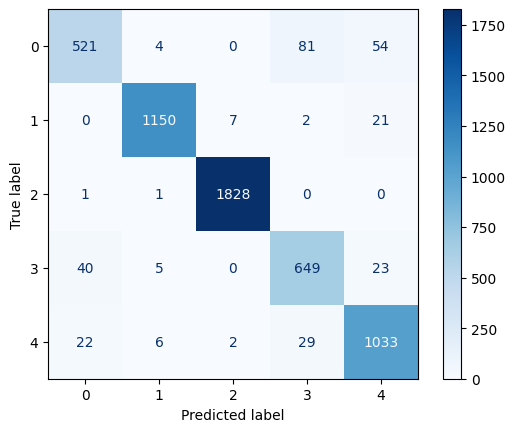

In [ ]:
# Confusion matrix to evaluate network accuracy
y_pred = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()

# **Saving model in Keras .h5 format**

In [ ]:
# Function definition to estimate model size
import os

def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' KB')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' MB')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [ ]:
# Save model in HD5 format
saved_model = "har_model.h5"
model.save(saved_model)

!ls

dataset_split.mat  har_model.h5  sample_data


In [ ]:
# Download saved model
try:
  from google.colab import files
  files.download(saved_model)
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Calculate model size
convert_bytes(get_file_size(saved_model), "MB")
get_file_size(saved_model)

File size: 0.216 MB


226296

# **Conversion to TensorFlow Lite**

In [ ]:
model = tf.keras.models.load_model('har_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

converter._experimental_lower_tensor_list_ops = False

tflite_fp32 = converter.convert()

path = pathlib.Path('har_model_fp32.tflite')
path.write_bytes(tflite_fp32)
print(f'Saved {path.name}, size {os.path.getsize(path)/1024:.1f} kB')


Saved artifact at '/tmp/tmpyp0bz5_i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 6), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132449679952400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449679959504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449679966032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449679955664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449679956240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449679958352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449679961424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449679954896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449679962768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449679965648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132449679962960: Ten

In [ ]:
# Download the generated file
files.download('har_model_fp32.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Saving test data for STM32 validation**

In [ ]:
# Saving test data for STM32 validation
print(X_test.shape)
print(y_test.shape)
print((len(y_test),))

# npy file format
np.save("x_test_tensor.npy", X_test)
np.save("y_test_tensor.npy", y_test)

(5539, 100, 6)
(5539,)
(5539,)


In [ ]:
# Download test files
try:
  from google.colab import files
  files.download("x_test_tensor.npy")
  files.download("y_test_tensor.npy")
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Saving test data for STM32 Validation
y_test_one_hot_labels = keras.utils.to_categorical(y_test, num_classes=5)
print(y_test_one_hot_labels.shape)
print(y_test_one_hot_labels[0])

# Saving X_test from numpy array to CSV array
np.savetxt('X_test.csv', X_test.reshape(X_test.shape[0], -1), delimiter=",")
# Saving y_test from numpy array to CSV array
np.savetxt('y_test.csv', y_test_one_hot_labels, delimiter=",")

(5539, 5)
[1. 0. 0. 0. 0.]


In [ ]:
# Download test files
try:
  from google.colab import files
  files.download("X_test.csv")
  files.download("y_test.csv")
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Weights extraction and .c and .h file generation**

In [ ]:
# Input file
model_path = "/content/har_model.h5"
model = tf.keras.models.load_model(model_path)

# Output
c_file_path = "/content/model_weights.c"
h_file_path = "/content/model_weights.h"

c_file = open(c_file_path, "w")
h_file = open(h_file_path, "w")
h_file.write("#pragma once\n\n")

def sanitize_name(name):
    return name.replace("/", "_").replace(":", "_").replace("-", "_")

def write_array(name, array):
    clean_name = sanitize_name(name)
    shape = array.shape
    array = np.array(array).astype(np.float32)

    if len(shape) == 1:
        c_file.write(f"const float {clean_name}[{shape[0]}] = {{\n")
        for val in array:
            c_file.write(f"  {val:.8e}f,\n")
        c_file.write("};\n\n")
        h_file.write(f"extern const float {clean_name}[{shape[0]}];\n")

    elif len(shape) == 2:
        c_file.write(f"const float {clean_name}[{shape[0]}][{shape[1]}] = {{\n")
        for row in array:
            c_file.write("  { " + ", ".join(f"{val:.8e}f" for val in row) + " },\n")
        c_file.write("};\n\n")
        h_file.write(f"extern const float {clean_name}[{shape[0]}][{shape[1]}];\n")

    elif len(shape) == 3:
        flat_shape = (shape[0], shape[1] * shape[2])
        array = array.reshape(flat_shape)
        c_file.write(f"const float {clean_name}[{flat_shape[0]}][{flat_shape[1]}] = {{\n")
        for row in array:
            c_file.write("  { " + ", ".join(f"{val:.8e}f" for val in row) + " },\n")
        c_file.write("};\n\n")
        h_file.write(f"extern const float {clean_name}[{flat_shape[0]}][{flat_shape[1]}];\n")

    elif len(shape) == 4:
        flat_shape = (shape[0], shape[1] * shape[2] * shape[3])
        array = array.reshape(flat_shape)
        c_file.write(f"const float {clean_name}[{flat_shape[0]}][{flat_shape[1]}] = {{\n")
        for row in array:
            c_file.write("  { " + ", ".join(f"{val:.8e}f" for val in row) + " },\n")
        c_file.write("};\n\n")
        h_file.write(f"extern const float {clean_name}[{flat_shape[0]}][{flat_shape[1]}];\n")

    else:
        print(f"Skipping unsupported shape {shape} in {name}")

# Estrazione pesi
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    if weights:
        for j, w in enumerate(weights):
            var_name = f"weights_{i}_{j}"
            write_array(var_name, w)

c_file.close()
h_file.close()

# Print file names
print(c_file_path)
print(h_file_path)


File salvati:
/content/model_weights.c
/content/model_weights.h
